## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 1,2 = velocity_y, volume_frac


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie, computeSpatialandTimePOD, rel_err

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

## Settings

In [ ]:
svdOutFile = '/data/ccsi/pnnl_liquid_inlet' 
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 1
gridsize = 128
svdOutFile = os.path.join(svdOutFile, 'channel_{}'.format(channel))
svdOutFile = svdOutFile + '/svd_channel{}_gridsize{}.pkl'.format(channel,gridsize)
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2
AE = True
numWorkers = 2

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 16
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 2
    numSamplesToKeep = 2
    
svdOutFile

'/data/ccsi/pnnl_liquid_inlet/channel_1/svd_channel1_gridsize128.pkl'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Thu Nov  5 12:12:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   22C    P8     8W / 250W |    497MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   17C    P8     8W / 250W |   1024MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN X (Pascal)


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Thu Nov  5 12:12:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   22C    P8     8W / 250W |    497MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P2    52W / 250W |   1511MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [ ]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE)
trainDataset = CCSI_2D(trainSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE)
len(trainDataset),len(testDataset)

(20000, 5000)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=len(trainDataset), num_workers=numWorkers)
testDataLoader = DataLoader(dataset=testDataset, batch_size=len(testDataset), num_workers=numWorkers)
len(trainDataLoader), len(testDataLoader)

(1, 1)

In [ ]:
X,_ = next(iter(trainDataLoader))
X.shape

torch.Size([20000, 1, 128, 128])

In [ ]:
if os.path.exists(svdOutFile):
    print('loading file...')
    D = pkl_load(svdOutFile)
    spatialVecs = D['spatialVecs']
    S = D['S']
    D['timeVecs_transpose'] = timeVecs_transpose
else:
    spatialVecs, S, timeVecs_transpose = computeSpatialandTimePOD(X,simLen,doPlot=True)
    D = {'spatialVecs':spatialVecs,'S':S,'timeVecs_transpose':timeVecs_transpose}
    pkl_save(D,svdOutFile)
    spatialVecs.shape, S.shape, timeVecs_transpose.shape

loading file...


In [ ]:
spatialVecs.shape

(16384, 16384)

In [ ]:
Ssum = S**2/np.sum(S**2)
Scumsum = np.cumsum(Ssum)

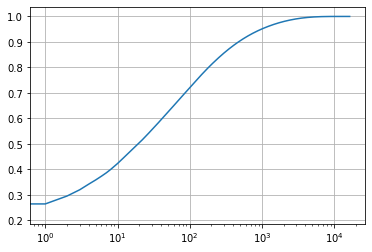

In [ ]:
plt.semilogx(Scumsum)
plt.grid()

## SVD Coeffs

In [ ]:
XX = X.reshape(X.shape[0],-1)
XX.shape

torch.Size([20000, 16384])

In [ ]:
numComp = 512
u = spatialVecs[:,:numComp]

In [ ]:
trainCoeffs = np.matmul(XX,u)
trainCoeffs.shape

torch.Size([20000, 512])

In [ ]:
A = []
for i in range(trainCoeffs.shape[0]//simLen):
    A.append(trainCoeffs[i*simLen:(i+1)*simLen])
A = np.stack(A)
trainCoeffs = A

In [ ]:
testData,_ = next(iter(testDataLoader))
testData.shape

torch.Size([5000, 1, 128, 128])

In [ ]:
testData = testData.reshape(testData.shape[0],-1)
testData.shape

torch.Size([5000, 16384])

In [ ]:
testCoeffs = np.matmul(testData,u)
testCoeffs.shape

torch.Size([5000, 512])

In [ ]:
A = []
for i in range(testCoeffs.shape[0]//simLen):
    A.append(testCoeffs[i*simLen:(i+1)*simLen])
A = np.stack(A)
testCoeffs = A
testCoeffs.shape

(10, 500, 512)

In [ ]:
B = np.matmul(u,testCoeffs[0].T).T
B.shape

(500, 16384)

In [ ]:
testCoeffs[0].shape

(500, 512)

In [ ]:
B = B.reshape(simLen,gridsize,gridsize)
B.shape

(500, 128, 128)

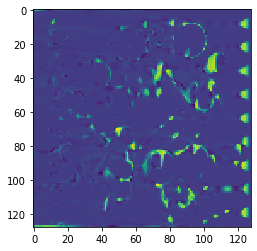

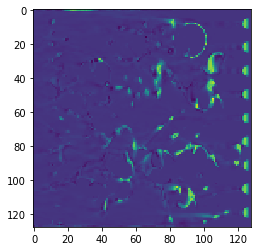

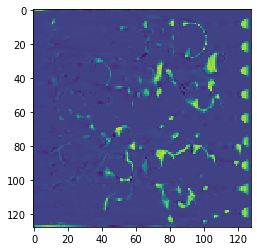

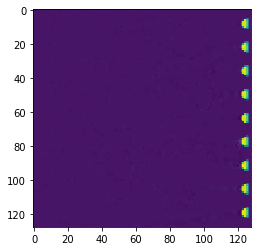

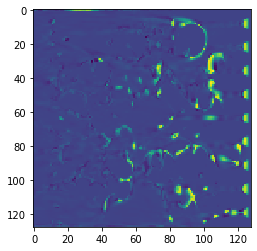

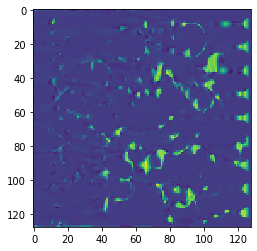

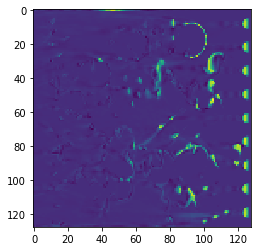

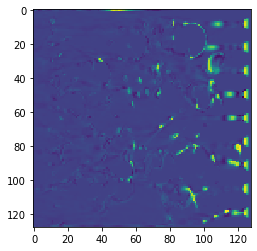

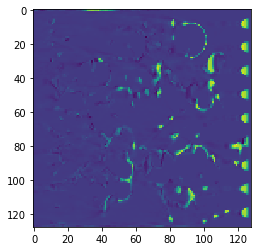

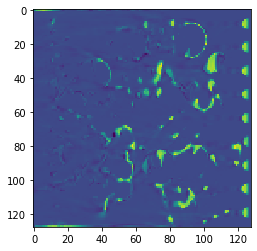

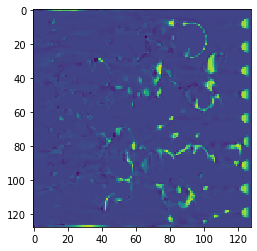

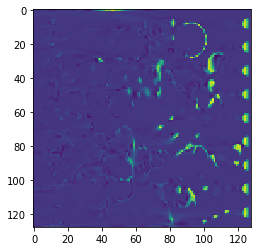

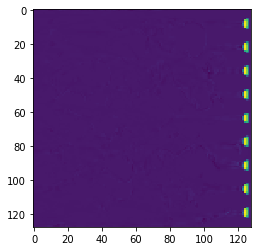

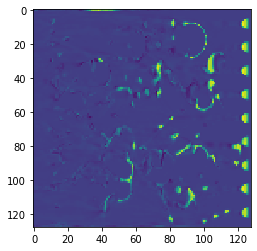

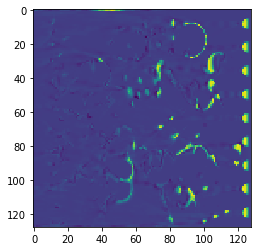

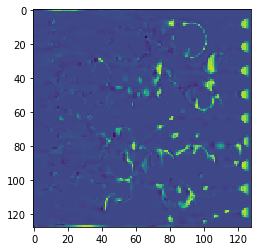

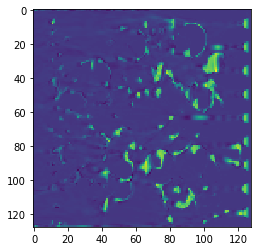

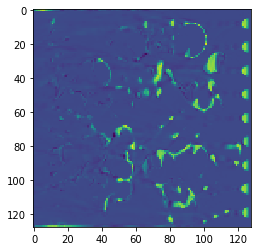

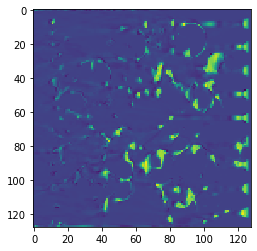

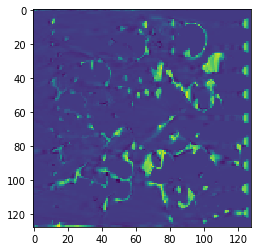

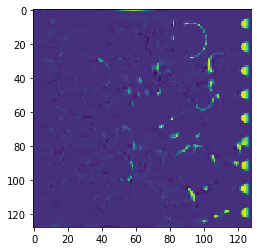

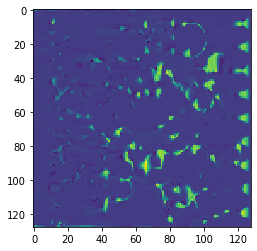

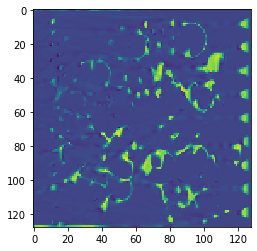

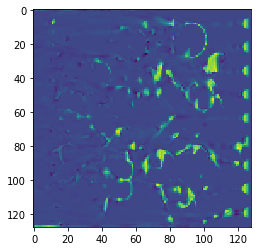

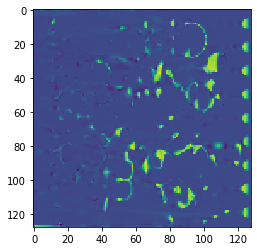

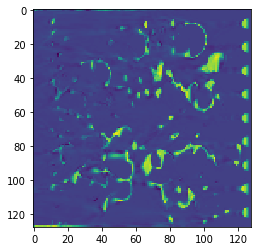

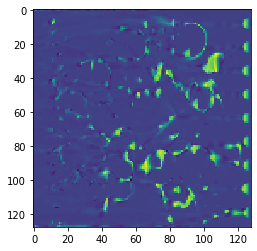

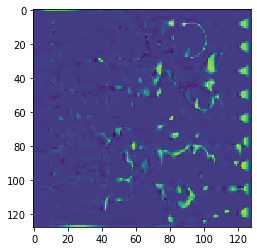

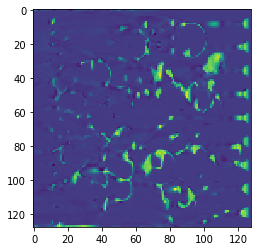

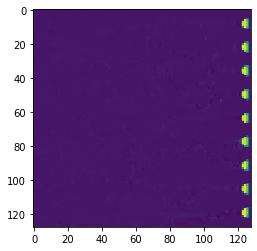

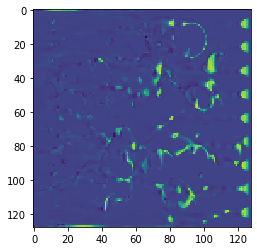

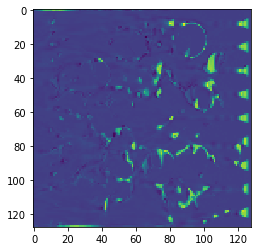

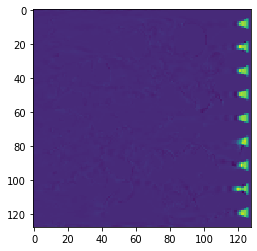

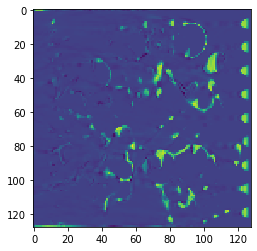

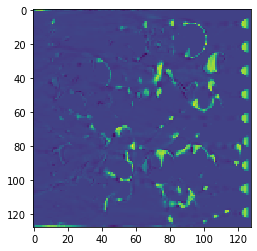

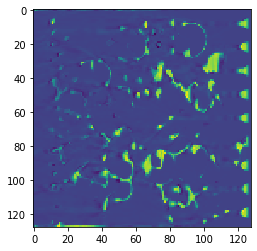

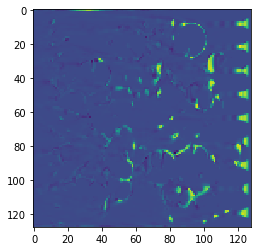

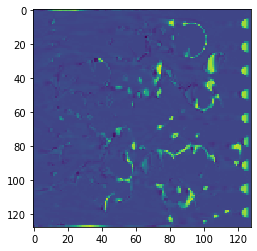

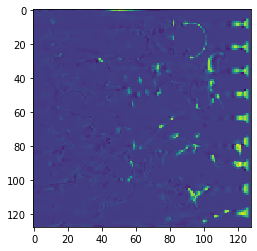

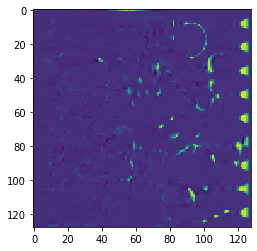

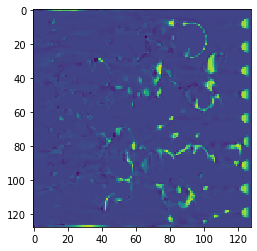

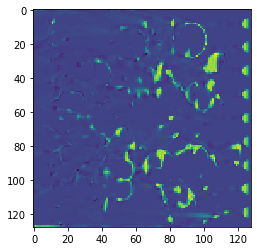

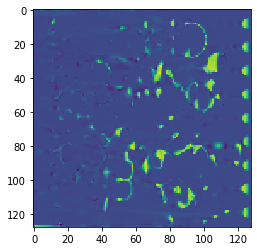

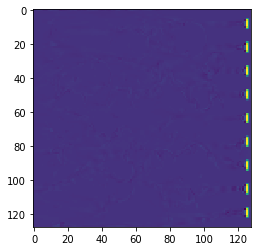

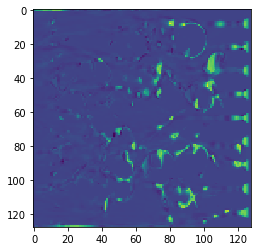

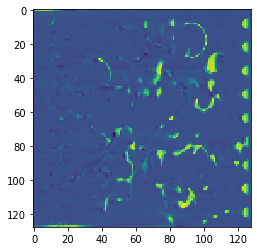

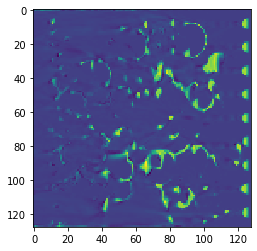

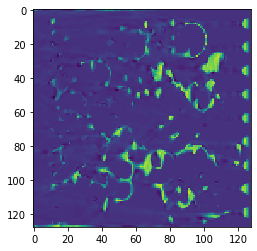

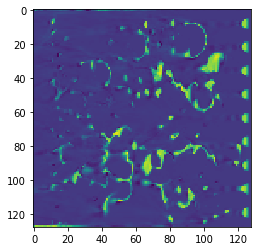

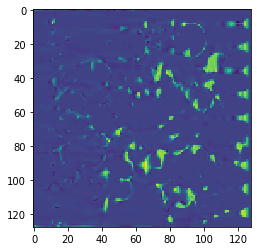

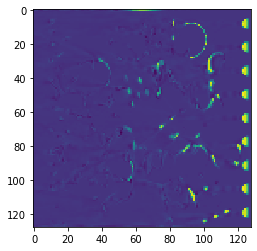

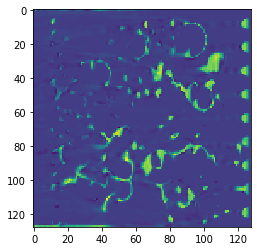

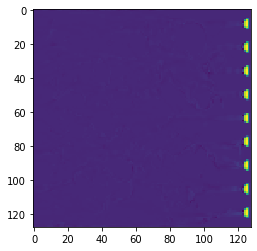

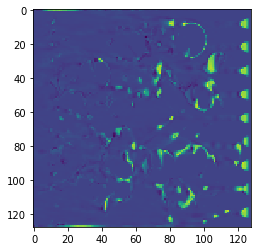

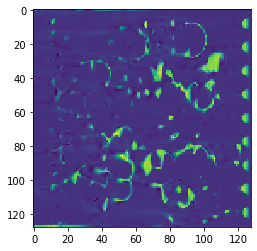

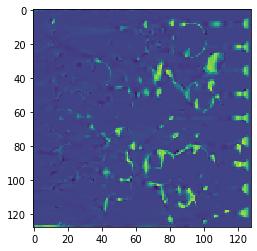

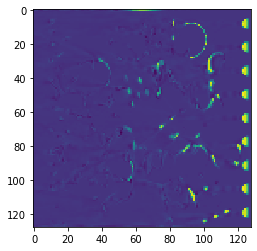

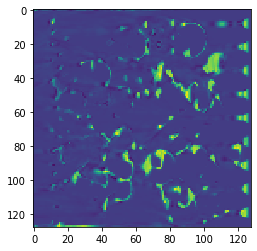

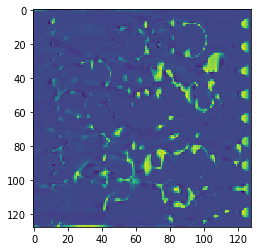

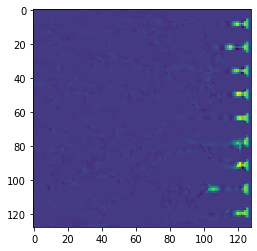

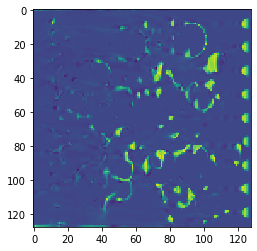

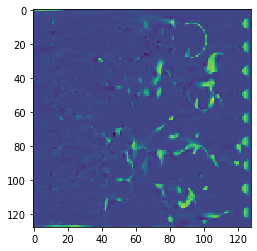

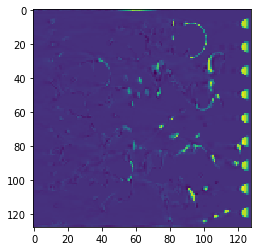

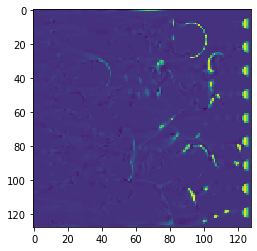

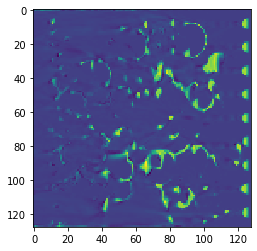

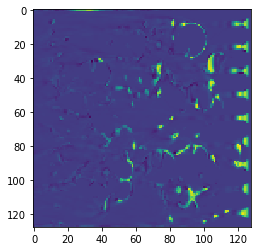

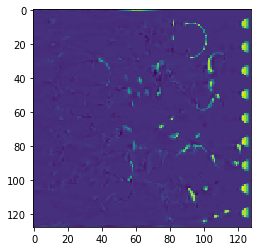

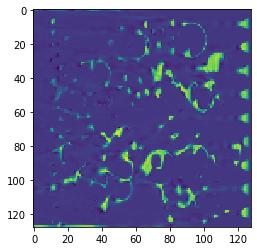

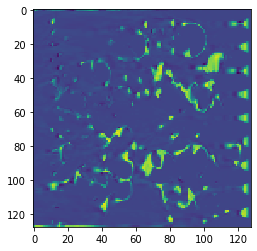

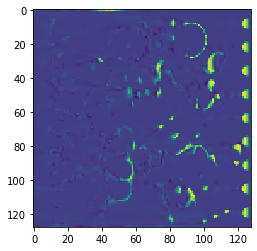

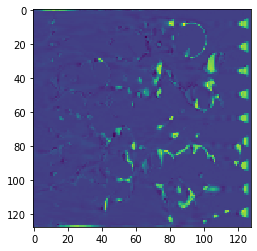

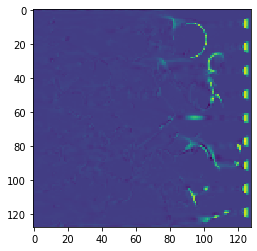

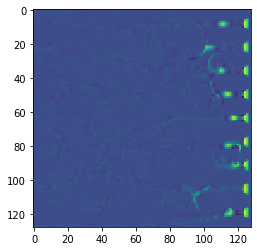

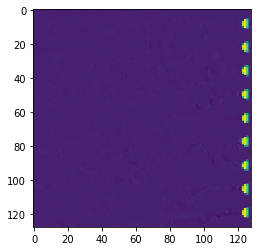

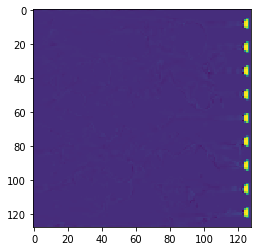

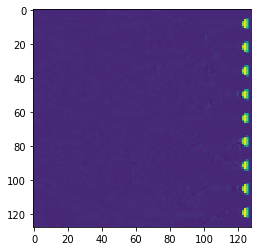

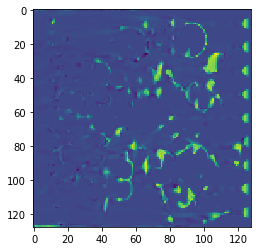

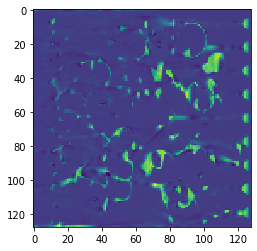

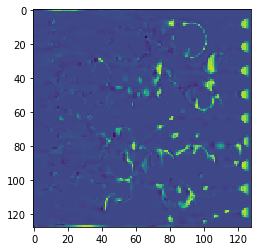

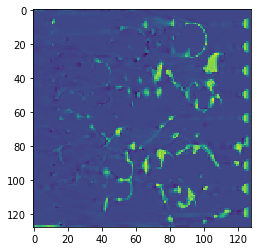

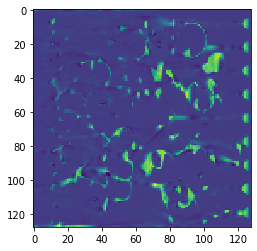

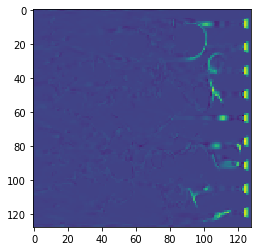

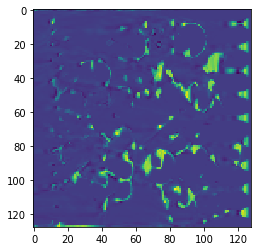

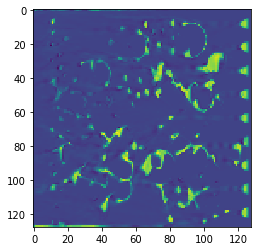

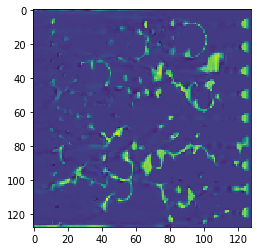

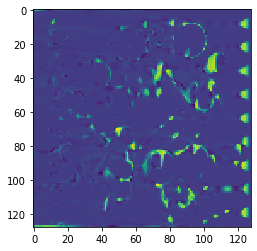

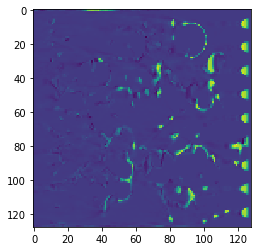

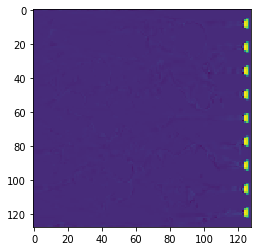

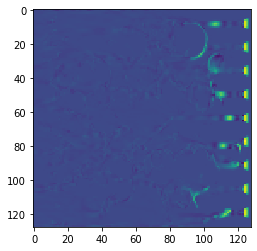

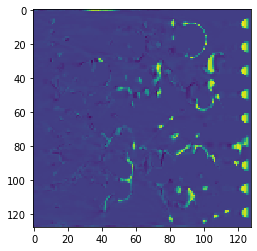

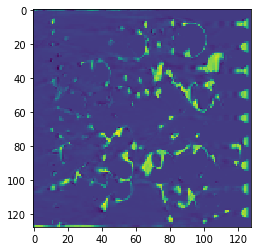

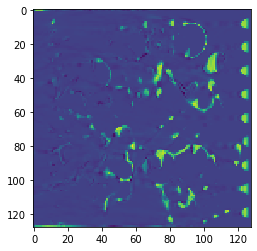

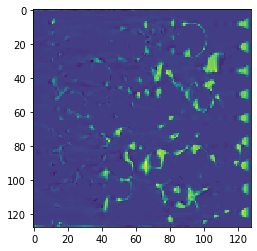

KeyboardInterrupt: 

In [ ]:
for b in B:
    plt.imshow(b)
    plt.show()

In [ ]:
C = testData[0:simLen].reshape(simLen,gridsize,gridsize).numpy()
print(C.shape)

(500, 128, 128)


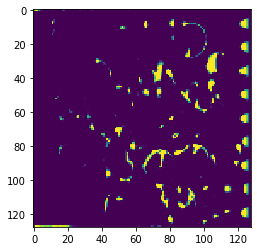

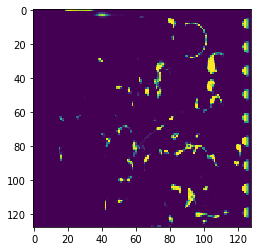

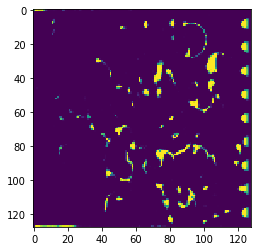

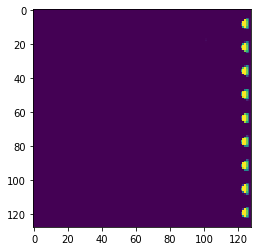

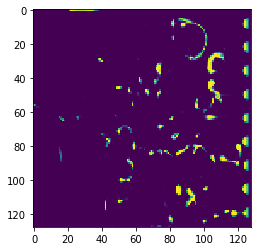

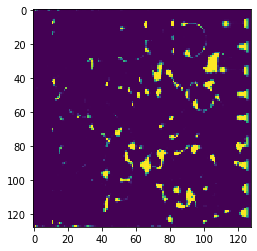

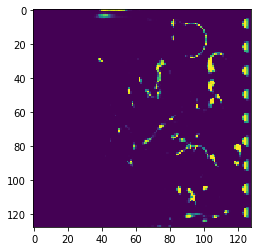

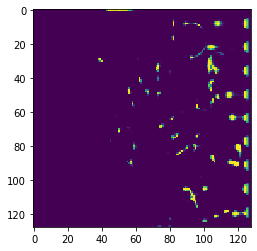

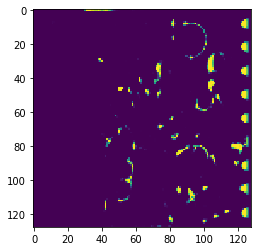

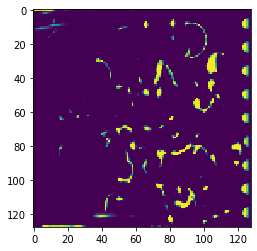

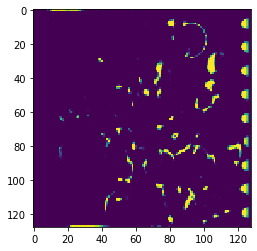

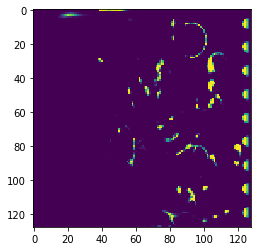

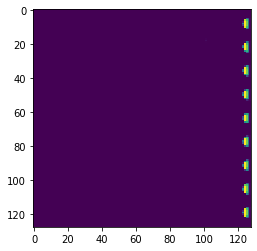

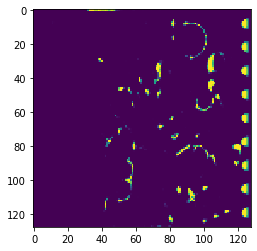

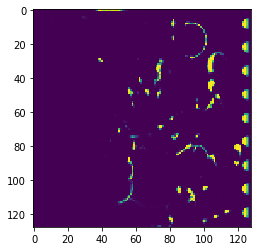

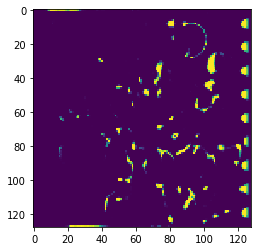

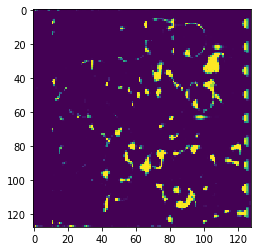

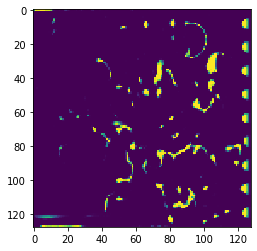

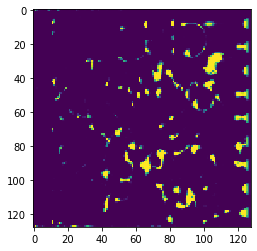

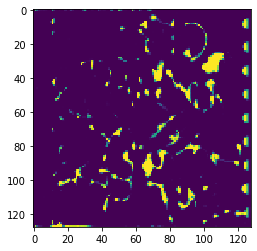

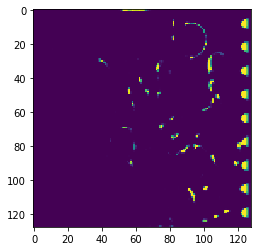

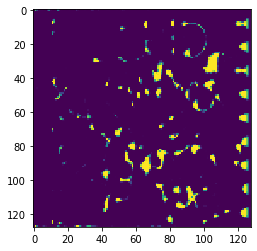

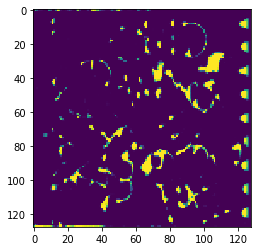

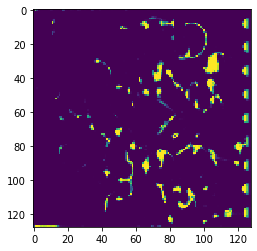

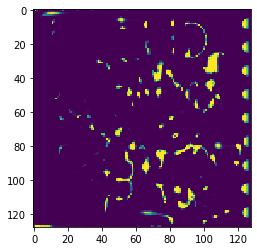

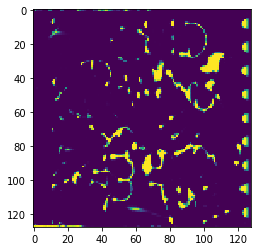

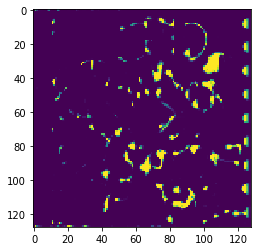

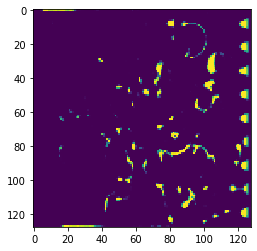

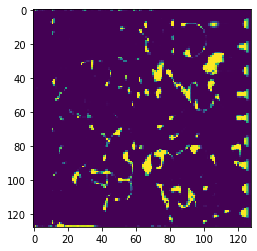

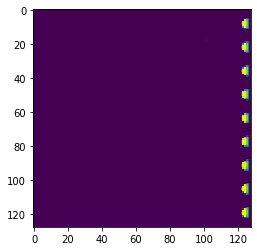

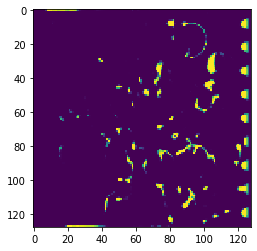

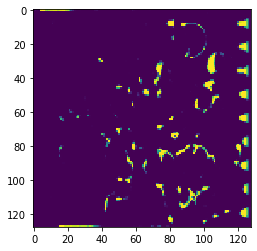

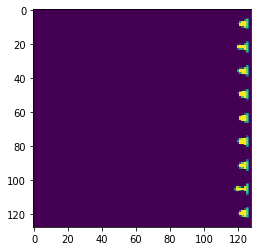

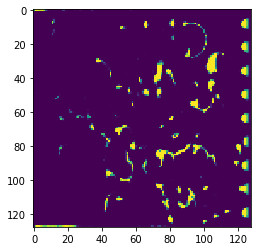

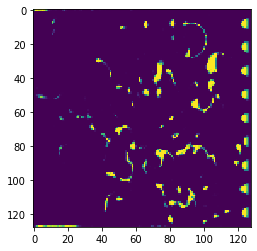

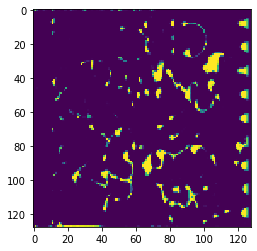

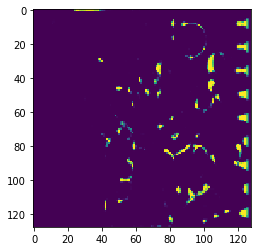

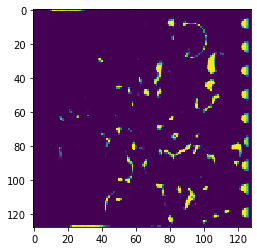

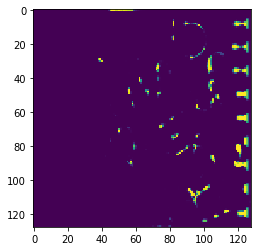

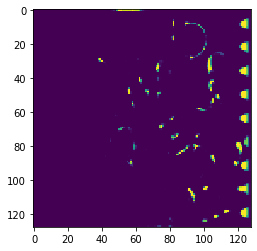

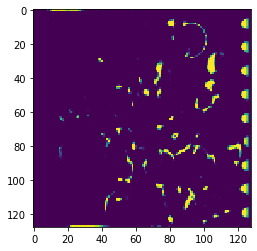

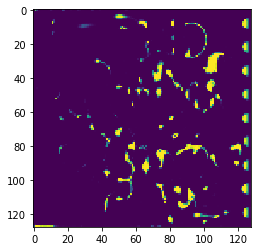

KeyboardInterrupt: 

In [ ]:
for c in C:
    plt.imshow(c)
    plt.show()

In [ ]:
re = rel_err(C,B)
re

0.32498196

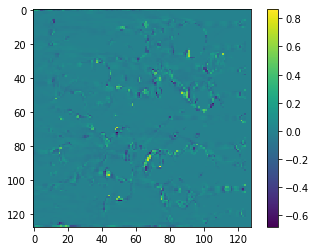

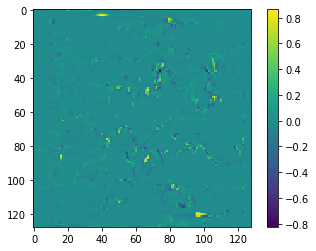

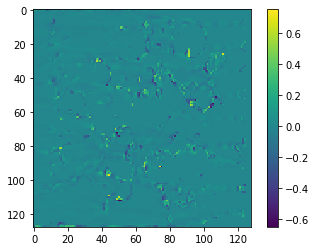

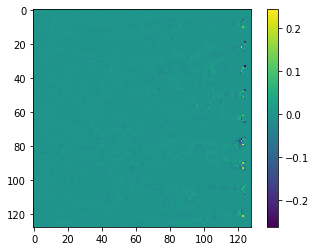

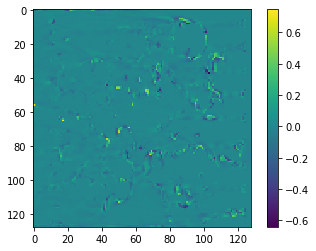

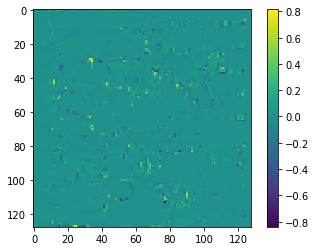

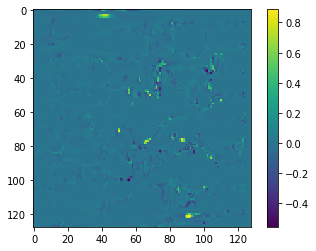

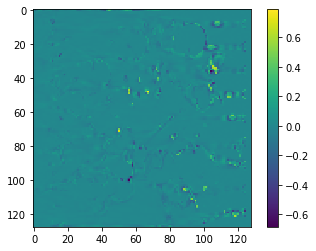

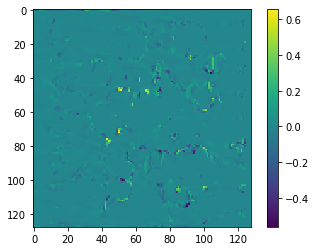

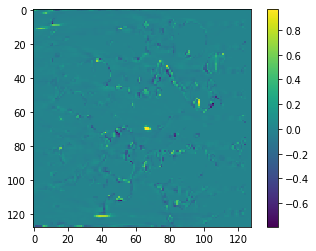

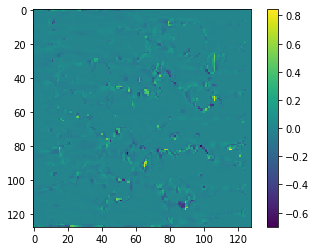

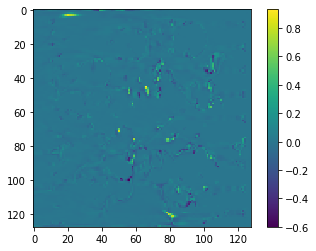

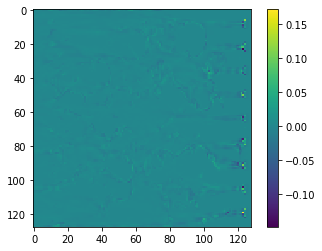

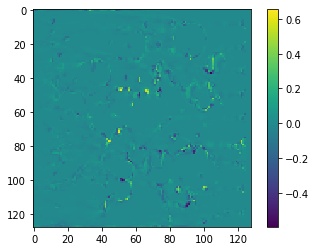

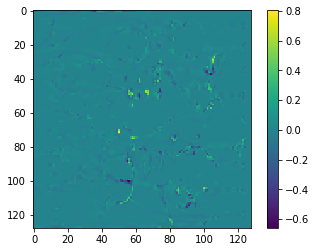

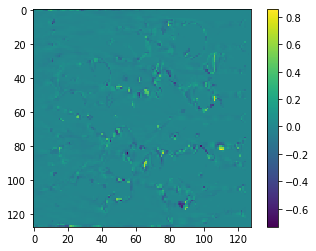

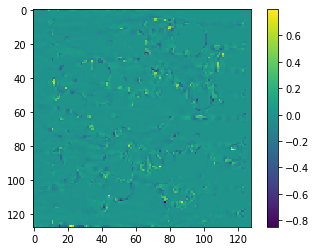

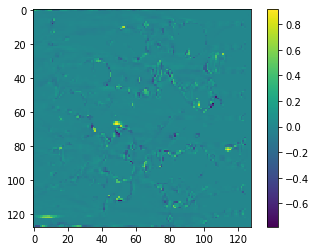

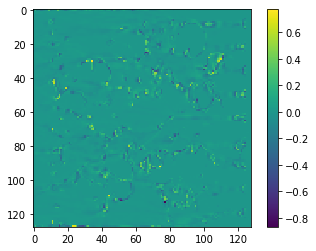

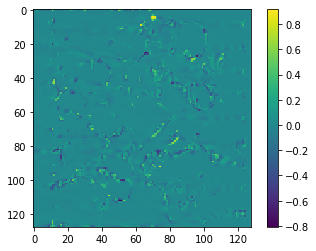

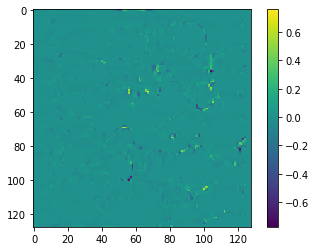

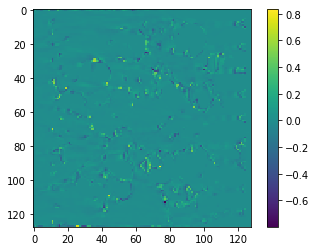

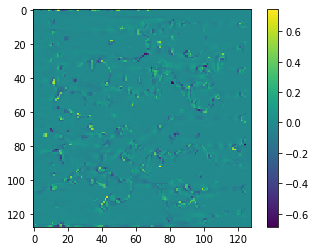

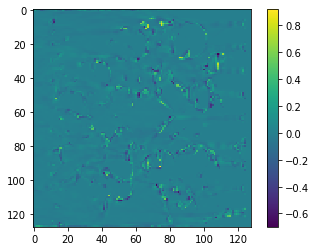

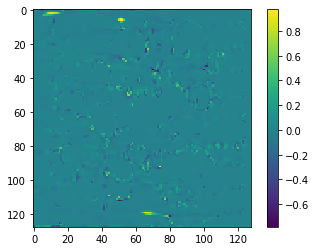

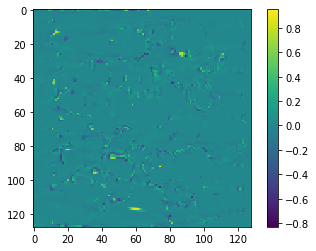

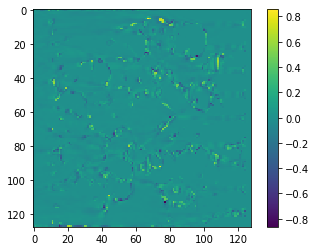

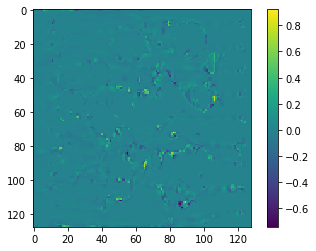

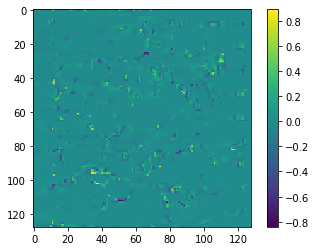

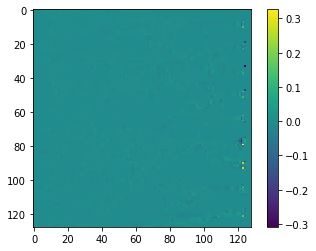

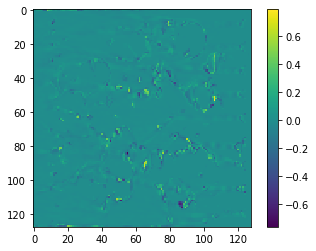

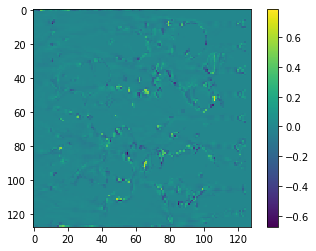

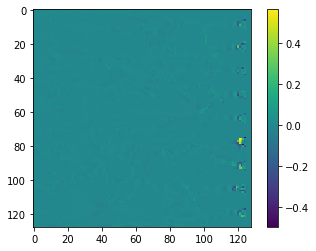

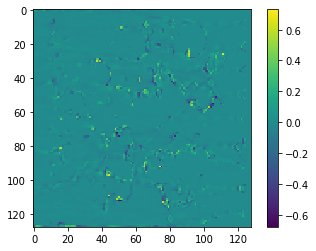

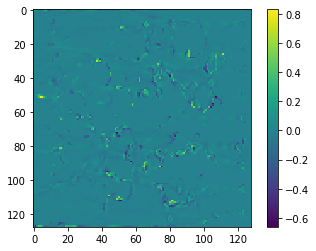

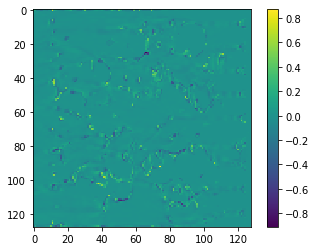

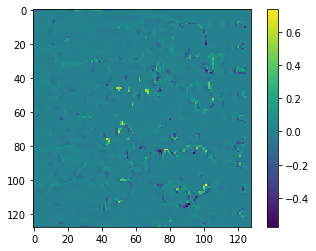

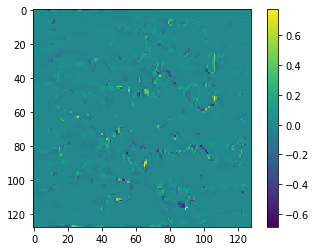

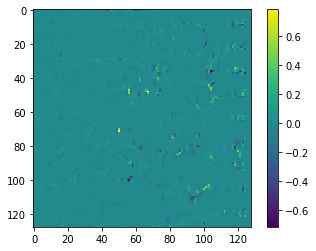

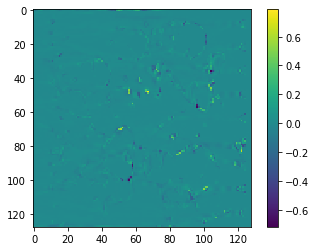

KeyboardInterrupt: 

In [ ]:
for b,c in zip(B,C):
    plt.imshow(c-b)
    plt.colorbar()
    plt.show()

In [ ]:
R = []
for b,c in zip(B,C):
    R.append(rel_err(c,b))


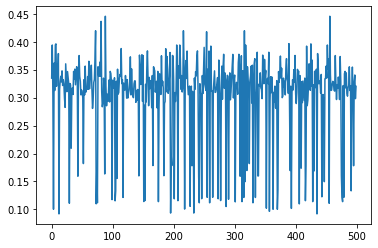

In [ ]:
plt.plot(R)